<p> Цель - создать джингл THX (почитать про историю - https://stereo.ru/news/thx-shared-musical-score-for-its-logo-jingle)
<p>
   <img src='https://img.stereo.ru/news/2018/6/d5c5154c854029af9af04778729427c4.jpg' width='400px'>
<p>На всякий случай вспомним ноты
<p>
    <img src='https://rock-academy.ru/Gallery/Image/30zzgt4vhgsced7kr5yk3a.jpg'>
    <img src='https://music-school37.ru/wp-content/uploads/2019/10/227586c16284580082fa69b2f4b449a0.png'>
<p><h1>Модель сигнала</h1>
<p>Для звука i, мы имеем следующую синусоиду (амплитуда и частота от времени):
    <img src='001.jpg'>
<p>На выходе получается сумма голосов:
    <img src='002.jpg'>
<p>В дискретном времени, для частоты / частоты дискретизации f_s:
    <img src='003.jpg'>
<p><h1>Этапы</h1>
<p><b>start</b> - частоты меняются случайным образом в узком частотном диапазоне, звуки тихие.
<p><b>transition</b> - звук движется к своей целевой частоте, и становится громче.
<p><b>sustain</b> - звук остается на своей целевой частоте, и становится еще громче.
<p><b>decay</b> - звук становится тише.
<p><b>t_end</b> - конец сигнала

In [1]:
t_start = 0
t_transition = 4
t_sustain = 10
t_decay = 14
t_end = 16

In [2]:
sr = 44100 # частота дискретизации

In [3]:
# преобразование времени в в единицы отсчетов
n_start = t_start*sr
n_transition = t_transition*sr
n_sustain = t_sustain*sr
n_decay = t_decay*sr
n_end = t_end*sr

In [4]:
import numpy as np
# ось времени
n = np.arange(n_end)
t = n/sr

<h1>Амлитуда</h1>

In [5]:
# Определение огибающей амплитуды для каждого из четырех (A(t)) 

amplitude_start = 0.1
amplitude_sustain = 1
amplitude_end = 0.01

In [6]:
# transition и decay будут увеличивать или уменьшать геометрическую / экспоненциальную последовательность:

amplitude_transition = np.geomspace(amplitude_start, amplitude_sustain, n_sustain-n_transition)
amplitude_decay = np.geomspace(amplitude_sustain, amplitude_end, n_end-n_decay)

In [7]:
amplitude = np.zeros(n_end)
amplitude[n_start:n_transition] = amplitude_start
amplitude[n_transition:n_sustain] = amplitude_transition
amplitude[n_sustain:n_decay] = amplitude_sustain
amplitude[n_decay:n_end] = amplitude_decay

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 4))
plt.semilogy(t, amplitude, linewidth=2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude Envelope')

Text(0, 0.5, 'Amplitude Envelope')

<h1>Частота</h1>
<p>Берем формулу звука i, что прописали выше:
    <img src='004.jpg'>
<p>Определяем:
    <img src='005.jpg'>
<p>Если f_i остается неизменным с течением времени, то возможно записатье правило обновления:
    <img src='006.jpg'>
<p>Если f_i[n] меняется во времени, то все еще проще:
    <img src='007.jpg'>
<p>Это правило обновления представляет собой просто совокупную сумму f_i[n]
<br>
<p>Остается определить частоты во время финальной фазы, то есть последних четырех тактов. 
<p>Переведем камертон в  448 Hz (https://ru.wikipedia.org/wiki/Камертон_(эталон_высоты)). И определяем ноты в A и D в разных октавах.
<p>Берем Пифагоров строй (https://en.wikipedia.org/wiki/Пифагоров_строй): является октавно-квинтовым строем, порождаемым натуральными интервалами чистой октавы (1:2) и чистой квинты (2:3).    

In [9]:
f_sustain = [448*x for x in [1/12, 1/8, 1/6, 1/4, 1/3, 1/2, 2/3, 1, 4/3, 2, 8/3, 4, 16/3, 8]] * 3

In [10]:
num_voices = len(f_sustain)

print('итоговое количество звуков: ', num_voices)

итоговое количество звуков:  42


In [12]:
import librosa

# создание частот от времени для каждого звука

fmin = librosa.note_to_hz('C0')
fmax = librosa.note_to_hz('C9')
n_bins = 9*12 # 9 octaves

(16.351597831287414, 8372.018089619156)

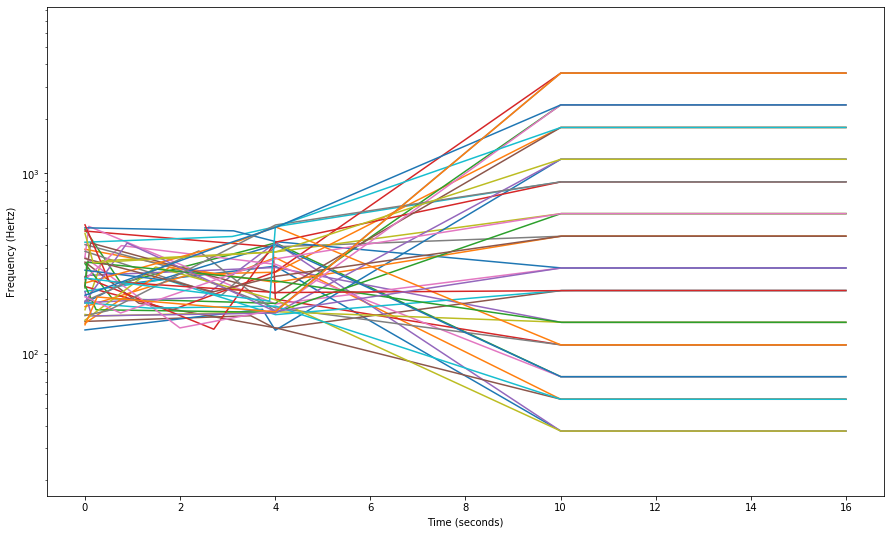

In [13]:
phi = [None]*num_voices
f_lo = librosa.note_to_hz('C3')
plt.figure(figsize=(15, 9))

for voice in range(num_voices):
    
    # частотный массив
    f = np.zeros(n_end)

    # начальные частоты случайны между C3 и C5. 
    f1 = f_lo*4**np.random.rand()
    f2 = f_lo*4**np.random.rand()
    f_transition = f_lo*4**np.random.rand()

    # один случайный момент времени на начальном этапе. 
    n1 = np.random.randint(n_start, n_transition) 

    # частоты для каждого этапа 
    f[n_start:n1] = np.geomspace(f1, f2, n1-n_start)
    f[n1:n_transition] = np.geomspace(f2, f_transition, n_transition-n1)
    f[n_transition:n_sustain] = np.geomspace(f_transition, f_sustain[voice], n_sustain-n_transition)
    f[n_sustain:n_end] = f_sustain[voice]
    
    # правило обновления
    phi[voice] = np.cumsum(f)
    
    # Частота графика. 
    plt.semilogy(t, f)
    
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hertz)')
plt.ylim(fmin, fmax)

<h1>Синтезируем

In [16]:
# output signal
out_signal = np.zeros(n_end)

# выходной сигнал, по одному голосу за раз
for voice in range(num_voices):
    out_signal += np.sin(2*np.pi/sr*phi[voice])

In [17]:
# нормализация амплитуды сигнала

out_signal *= amplitude
out_signal *= (0.99/out_signal.max())

In [19]:
import IPython.display as ipd

ipd.Audio(out_signal, rate=sr)

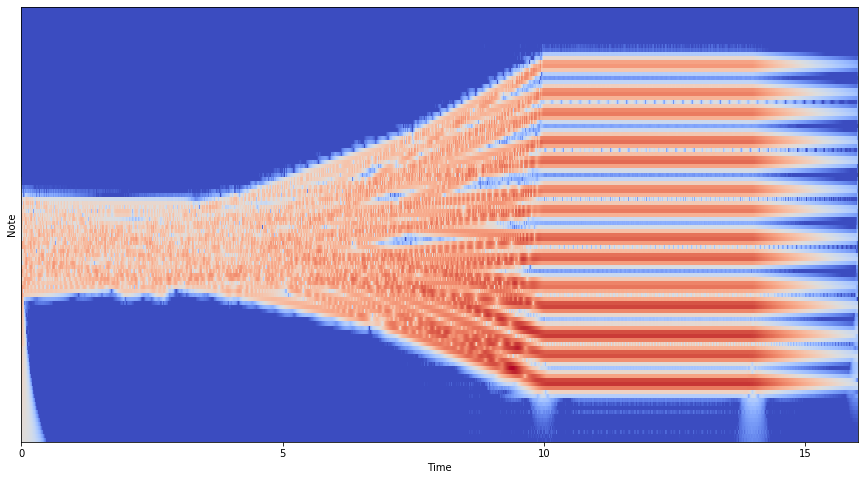

In [21]:
import librosa.display

C = librosa.cqt(out_signal, sr=sr, 
                fmin=fmin, n_bins=n_bins)
C_db = librosa.amplitude_to_db(abs(C))
plt.figure(figsize=(15, 8))
librosa.display.specshow(C_db, sr=sr, x_axis='time', y_axis='cqt_note', 
                         fmin=fmin, cmap='coolwarm')

Исходник: https://www.reddit.com/r/dataisbeautiful/comments/eqxf5v/animated_spectrogram_of_the_thx_logo_theme_with/

<p><img src='https://i.ytimg.com/vi/goOdpSEVLig/maxresdefault.jpg' width='300 px'>